# Прогнозирование временных рядов.   
**Лабораторная работа №8**

**ФИО: Шатаров Кирилл Александрович**

**Задание 1.**

В задании для примера используется база курса акций Course.csv (ссылка https://drive.google.com/file/d/1LlQd1xtjO47h-GO94BK704Jp0F6h5z6I/view?usp=sharing).   
В задании для самостоятельной разработки необходимо загрузить датасет и создать 3 архитектуры сети с использованием полносвязной архитектуры, одномерной свертки и рекуррентного слоя (MLP, Conv1D, LSTM).   
1. Создайте и  обучите простую полносвязную сеть для прогнозирования временного ряда (только показатель close) и выведите график ошибки.   
2. Постройте графики сравнения предсказания с оригинальным значением временного ряда.      
3. Создайте и обучите сверточную сеть для прогнозирования (только показатель close) и выведите график ошибки.   
4. Постройте графики сравнения предсказания с оригинальным значением временного ряда.   
5. Создайте и обучите сеть для прогнозирования с использованием LSTM слоя.   
6.  Выведите лучшую архитектуру сети.   


**Основные понятия статистического анализа временных рядов:**

**Тренд** - компонента, описывающая долгосрочное изменение уровня ряда.

**Сезонность** - компонента, обозначаемая как Q, описывает циклические изменения уровня ряда.

**Ошибка**(random noise) - непрогнозируемая случайная компонента, описывает нерегулярные изменения в данных, необъяснимые другими компонентами.

**Автокорреляция** -статистическая взаимосвязь между последовательностями величин одного ряда. Это один из самых важных коэффициентов в анализе временного ряда. Чтобы посчитать автокорреляцию, используется корреляция между временным рядом и её сдвинутой копией от величины временного сдвига. Сдвиг ряда называется лагом.

**Автокорреляционная функция**- график автокорреляции при разных лагах.

**Стационарный ряд** - ряд, в котором свойства не зависят от времени.



### Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils

import numpy as np
from keras import layers
from keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D,  LSTM, GlobalMaxPooling1D, MaxPooling1D
import gdown

import os
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gdown
# import matplotlib.pyplot as plt
# %matplotlib inline
import plotly
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [3]:
# from pylab import rcParams
# plt.style.use('ggplot')
# rcParams['figure.figsize'] = (14, 7)

### Загрузка данных

**Цифровая валюта (биткоин) - Временной ряд**  
Ссылка на данные: https://www.kaggle.com/datasets/ahmedadam415/digital-currency-time-series/data   
Ежедневные акции биткоинов (доллары США и саудовские риялы, SAR) | 2018-2021   
   
Данные содержат исторические ежедневные временные ряды для цифровой валюты (BTC), торгуемой на рынке Саудовской Аравии (SAR/Sudi Riyal).  
Цены и объемы указаны в саудовских риялах и долларах США.   
Диапазон дат данных: 2018-05-11 по 30.01.2021   

In [3]:
df = pd.read_csv('dc.csv', index_col=0)
# Выведем информацию о датасете
df.head()

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


In [4]:
df.tail()

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
2018-05-11,33761.888384,9002.21,33816.606720,9016.80,31282.086400,8341.00,31503.360000,8400.00,48227
2018-05-10,34916.224000,9310.00,35235.458048,9395.12,33641.088000,8970.00,33761.850880,9002.20,25055
2018-05-09,34421.171200,9178.00,35216.256000,9390.00,33622.336000,8965.00,34916.224000,9310.00,25673
2018-05-08,35122.496000,9365.00,35537.665280,9475.70,33980.649216,9060.54,34457.025024,9187.56,25533
2018-05-07,36232.689408,9661.02,36340.138368,9689.67,34432.422400,9181.00,35122.496000,9365.00,33787


In [182]:
df.shape

(1000, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 2021-01-30 to 2018-05-07
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open_SAR   1000 non-null   float64
 1   open_USD   1000 non-null   float64
 2   high_SAR   1000 non-null   float64
 3   high_USD   1000 non-null   float64
 4   low_SAR    1000 non-null   float64
 5   low_USD    1000 non-null   float64
 6   close_SAR  1000 non-null   float64
 7   close_USD  1000 non-null   float64
 8   volume     1000 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 78.1+ KB


In [7]:
df = df.sort_index(ascending=True)
df.head()

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
2018-05-07,36232.689408,9661.02,36340.138368,9689.67,34432.422400,9181.00,35122.496000,9365.00,33787
2018-05-08,35122.496000,9365.00,35537.665280,9475.70,33980.649216,9060.54,34457.025024,9187.56,25533
2018-05-09,34421.171200,9178.00,35216.256000,9390.00,33622.336000,8965.00,34916.224000,9310.00,25673
2018-05-10,34916.224000,9310.00,35235.458048,9395.12,33641.088000,8970.00,33761.850880,9002.20,25055
2018-05-11,33761.888384,9002.21,33816.606720,9016.80,31282.086400,8341.00,31503.360000,8400.00,48227


In [8]:
base_data = df.drop(columns=['open_SAR', 'high_SAR', 'low_SAR', 'close_SAR']) # удалим лишние столбцы

In [10]:
data = base_data.to_numpy()

In [11]:
CHANNEL_NAMES = ['open_USD', 'high_USD', 'low_USD', 'close_USD', 'volume'] # Названия каналов для предсказания (столбцов)
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}

### Вывод графиков

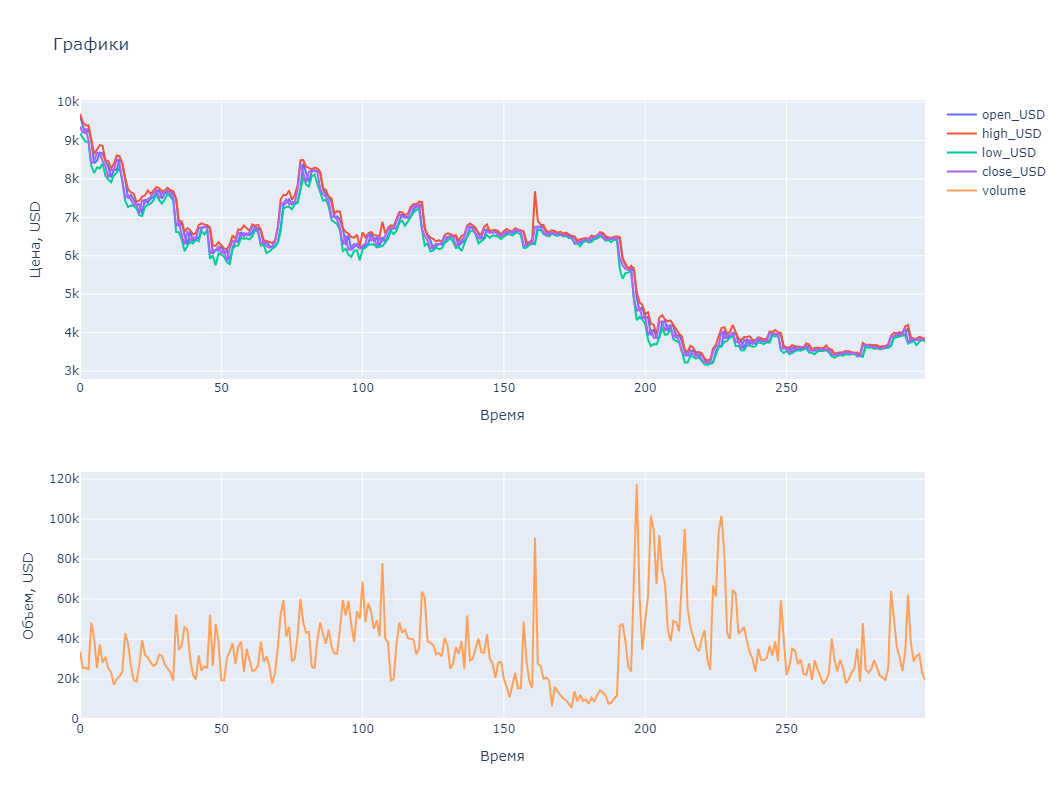

In [103]:
start = 0
length = 300

fig = go.Figure()

for chn in range(4):
    fig.add_trace(go.Scatter(
        x=list(range(length)),
        y=data[start:start + length, chn],
        mode='lines',
        name=CHANNEL_NAMES[chn],
        yaxis="y1",
        xaxis="x1"
    ))

fig.add_trace(go.Scatter(
    x=list(range(length)),
    y=data[start:start + length, 4],
    mode='lines',
    name=CHANNEL_NAMES[4],
    yaxis="y2",
    xaxis="x2"
))

fig.update_layout(
    title='Графики',
    xaxis1=dict(
        title='Время',
        domain=[0, 1],
        anchor='y1'
    ),
    xaxis2=dict(
        title='Время',
        domain=[0, 1],
        anchor='y2'
    ),
    yaxis=dict(
        title='Цена, USD',
        position=0,
        anchor='x',
        domain=[0.55, 1]
    ),
    yaxis2=dict(
        title='Объем, USD',
        position=0,
        anchor='x',
        domain=[0, 0.4]
    ),
    legend=dict(),
    width=1070, height=800
)

fig.show()


In [16]:
# Словарь каналов данных с их индексами
print(CHANNEL_INDEX)

{'open_USD': 0, 'high_USD': 1, 'low_USD': 2, 'close_USD': 3, 'volume': 4}


In [17]:
data.shape

(1000, 5)

In [132]:
# Задание гиперпараметров

CHANNEL_X = CHANNEL_NAMES                # Отбор каналов входных данных
CHANNEL_Y = ['close_USD']                # Отбор каналов данных для предсказания
SEQ_LEN = 10                             # Длина прошедших данных для анализа
BATCH_SIZE = 16                          # Объем батча для генератора
TEST_LEN = 300                           # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN     # Объем обучающей выборки

### Подготовка данных для обучения
Разделение данных на тренировочный и тестовый наборы, прохождение окном по наборам, масштабирование и создание генераторов обучающей и валидационной выбоки.

In [133]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными
# варьируемый параметр, страховка от пересечения
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train,
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

#  генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test,
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

[0, 1, 2, 3, 4] [3]
Train data: (700, 5), (700, 1)
Test  data: (280, 5), (280, 1)
Train batch x: (16, 10, 5), y: (16, 1)


In [134]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test,
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (270, 10, 5), y: (270, 1)


In [135]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и денормализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [136]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, start, length, chn_list=None, chn_names=CHANNEL_Y, title=''):
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Создание фигуры
    fig = go.Figure()

    # Построение графика по всем каналам данных
    for chn in chn_list:
        fig.add_trace(go.Scatter(
            x=list(range(start, start + length)),
            y=y_pred[start:start + length, chn],
            mode='lines',
            name=f'{chn_names[chn]} Прогноз'
        ))
        fig.add_trace(go.Scatter(
            x=list(range(start, start + length)),
            y=y_true[start:start + length, chn],
            mode='lines',
            name=f'{chn_names[chn]} Базовый'
        ))

    # Настройка осей и разметки графика
    fig.update_layout(
        title=title,
        xaxis=dict(
            title='Время',
            dtick=10
        ),
        yaxis=dict(
            title='Данные',
            dtick=2000
        ),
        legend=dict(title='Каналы'),
        width=1070, height=600
    )

    # Отображение графика
    fig.show()


In [137]:
def eval_net(model,
             x_test, y_test,
             y_scaler,
             start=0, length=400, back_steps_max=5, # параметры отображения графиков
             title=''):

    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    show_predict(y_pred[1:], y_true[:-1], start, length,
                 title=f'{title}: Сопоставление базового и прогнозного рядов')


In [138]:
def train_eval_net(model, train_datagen, val_datagen, epoch_list, x_test, y_test, y_scaler, start=0, length=400, back_steps_max=5, title=''):
    model.summary()

    for epochs, opt in epoch_list:
        model.compile(loss='mse', optimizer=opt)
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, verbose=1)

        # Построение графика ошибки обучения и валидации
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=list(range(len(history.history['loss']))),
            y=history.history['loss'],
            mode='lines',
            name='Ошибка на обучающем наборе'
        ))

        fig.add_trace(go.Scatter(
            x=list(range(len(history.history['val_loss']))),
            y=history.history['val_loss'],
            mode='lines',
            name='Ошибка на проверочном наборе'
        ))

        fig.update_layout(
            title=f'{title}: График прогресса обучения',
            xaxis_title='Эпоха обучения',
            yaxis_title='Средняя ошибка',
            legend=dict(title='Наборы данных'),
            width=1070, height=500
        )

        fig.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start, length=length, back_steps_max=back_steps_max, title=title)

## Создание и обучение полносвязной модели сети

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 10, 200)           1200      
                                                                 
 flatten_27 (Flatten)        (None, 2000)              0         
                                                                 
 dense_130 (Dense)           (None, 1)                 2001      
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Обучение 100 эпох
Epoch 1/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0156 - val_loss: 0.0766
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0528
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - 

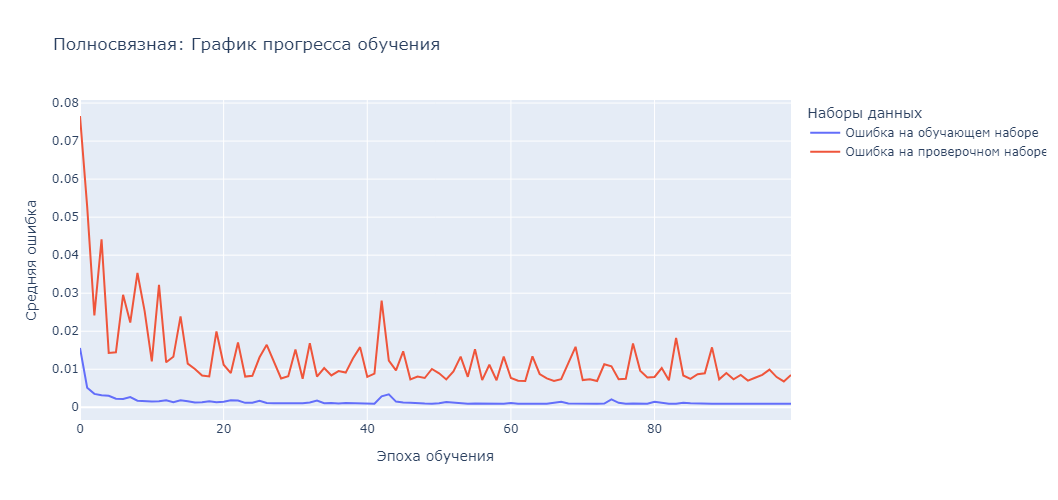

9/9 [==============================] - 0s 875us/step


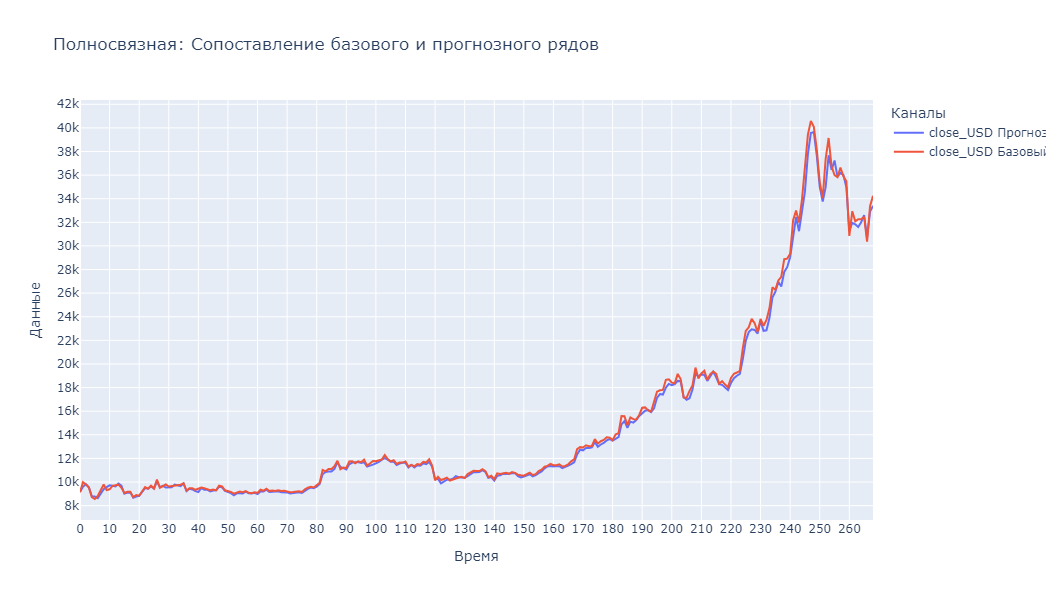

Обучение 100 эпох
Epoch 1/100
44/44 [==============================] - 0s 3ms/step - loss: 8.2520e-04 - val_loss: 0.0085
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 8.0539e-04 - val_loss: 0.0087
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 7.9476e-04 - val_loss: 0.0092
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 7.9300e-04 - val_loss: 0.0083
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 8.0001e-04 - val_loss: 0.0096
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 8.0268e-04 - val_loss: 0.0079
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 7.9132e-04 - val_loss: 0.0078
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 7.8884e-04 - val_loss: 0.0098
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 7.8059e-04 - val_loss: 0.0097
Epoch 10/100
44/44 [==============================] - 0

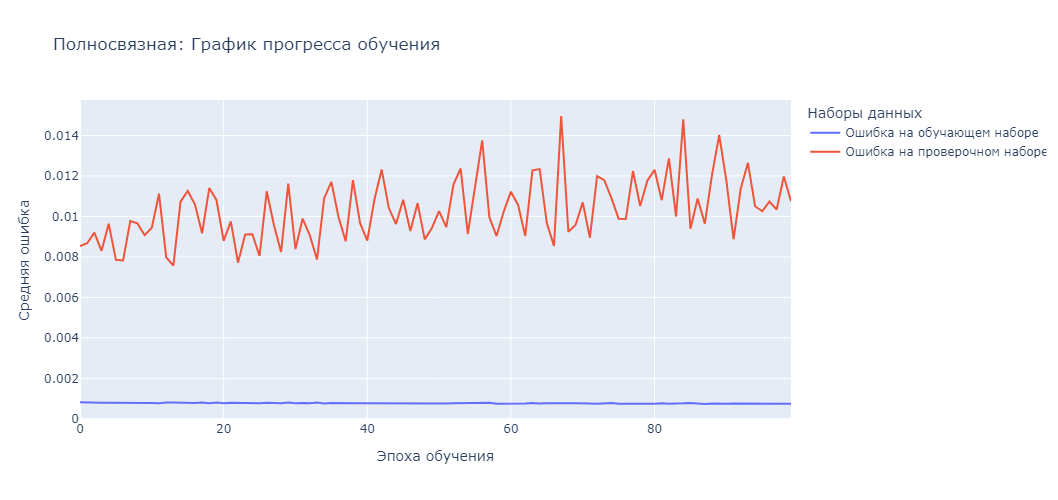

9/9 [==============================] - 0s 875us/step


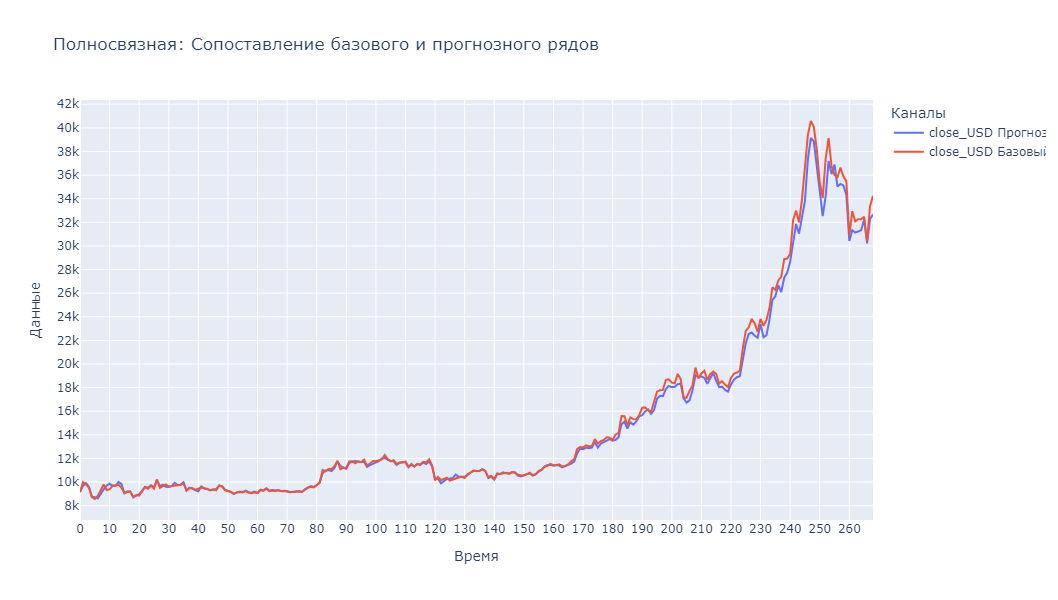

Обучение 100 эпох
Epoch 1/100
44/44 [==============================] - 0s 3ms/step - loss: 7.3449e-04 - val_loss: 0.0120
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 7.3100e-04 - val_loss: 0.0120
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 7.3175e-04 - val_loss: 0.0118
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 7.2873e-04 - val_loss: 0.0124
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 7.2839e-04 - val_loss: 0.0120
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 7.2782e-04 - val_loss: 0.0121
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 7.2873e-04 - val_loss: 0.0121
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 7.2947e-04 - val_loss: 0.0123
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 7.2796e-04 - val_loss: 0.0120
Epoch 10/100
44/44 [==============================] - 0

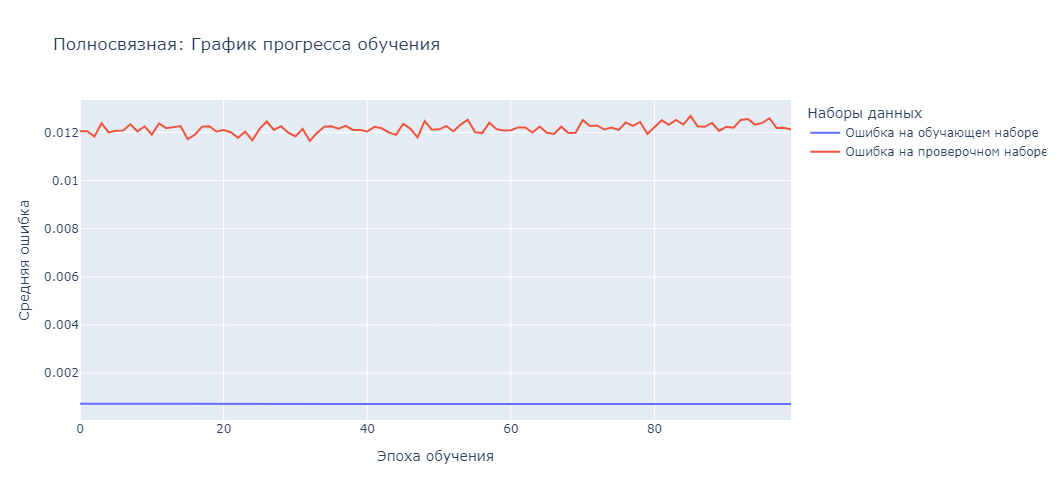

9/9 [==============================] - 0s 1ms/step


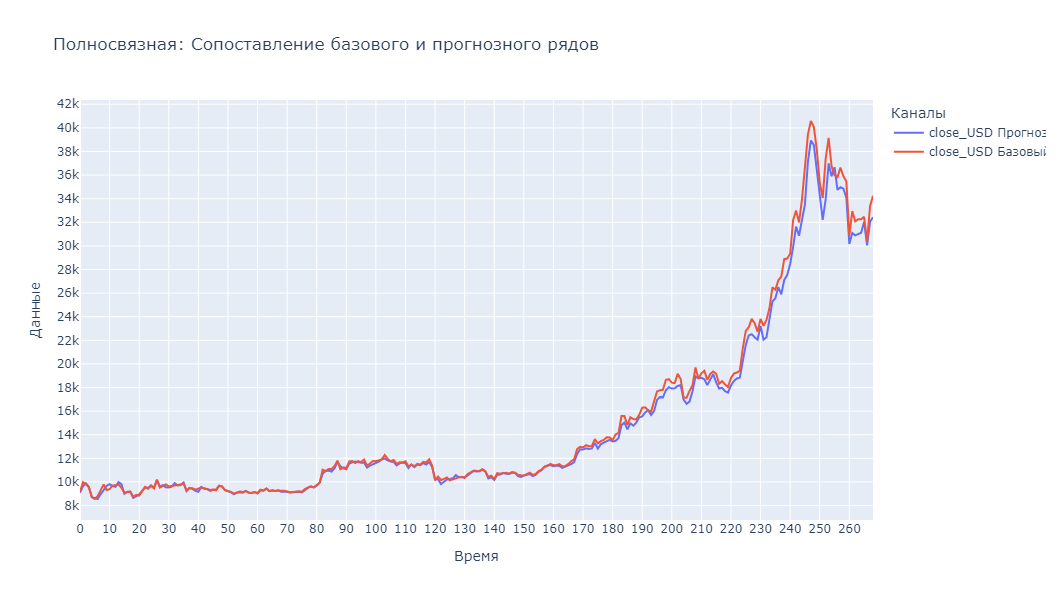

In [139]:
model_dense = Sequential() # Модель MLP

model_dense.add(Dense(200, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))
 # Модель MLP обучение с разными значениями learning_rate и вывод графиков
train_eval_net(model_dense, train_datagen, val_datagen, [(100, Adam(learning_rate=0.001)),
                                                         (100, Adam(learning_rate=0.0001)),
                                                         (100, Adam(learning_rate=0.00001))],
               title='Полносвязная', x_test=x_test, y_test=y_test, y_scaler=y_scaler)

## Создание и обучение сети с использованием одномерной свертки

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_26 (Conv1D)          (None, 6, 128)            3328      
                                                                 
 conv1d_27 (Conv1D)          (None, 2, 64)             41024     
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 flatten_28 (Flatten)        (None, 64)                0         
                                                                 
 dense_131 (Dense)           (None, 100)               6500      
                                                                 
 dense_132 (Dense)           (None, 32)                3232      
                                                     

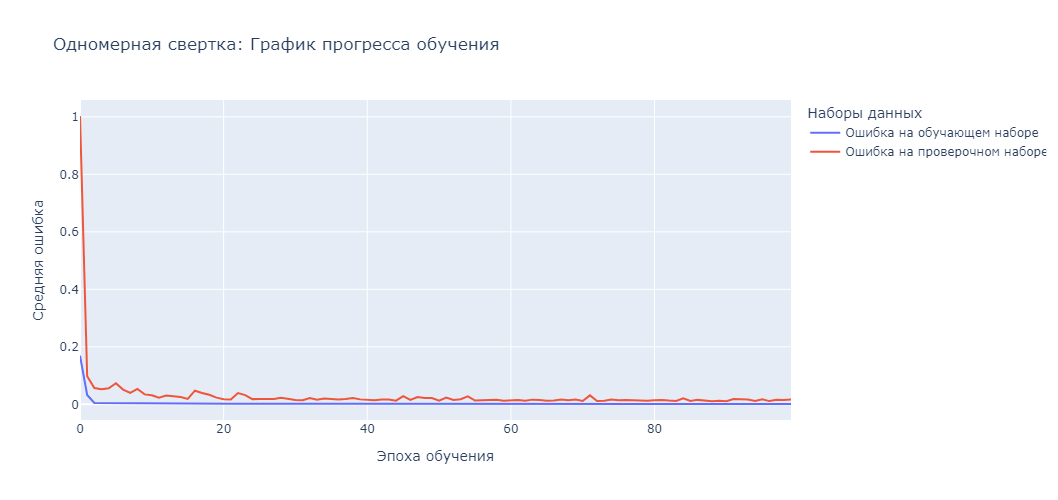

9/9 [==============================] - 0s 1ms/step


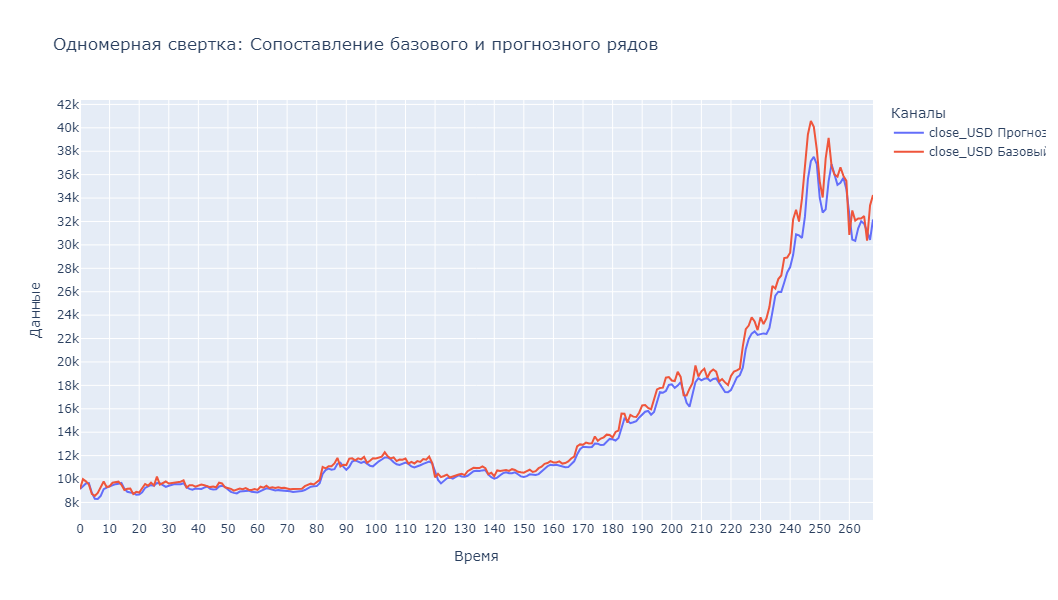

Обучение 100 эпох
Epoch 1/100
44/44 [==============================] - 1s 4ms/step - loss: 9.9903e-04 - val_loss: 0.0131
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 9.8171e-04 - val_loss: 0.0113
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0124
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 9.8606e-04 - val_loss: 0.0133
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 9.8406e-04 - val_loss: 0.0133
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 9.7698e-04 - val_loss: 0.0122
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 9.7408e-04 - val_loss: 0.0128
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 9.7414e-04 - val_loss: 0.0127
Epoch 9/100
44/44 [==============================] - 0s 2ms/step - loss: 9.7884e-04 - val_loss: 0.0122
Epoch 10/100
44/44 [==============================] - 0s 2m

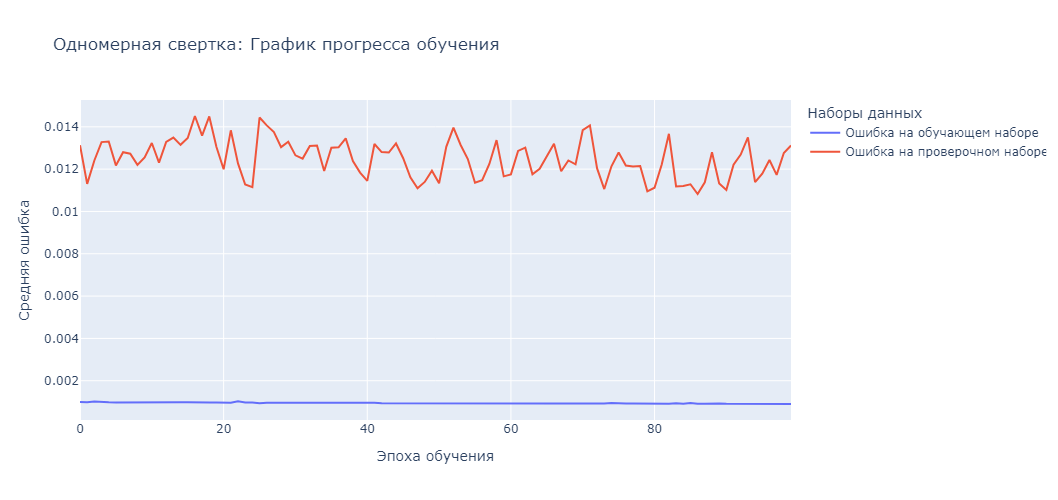

9/9 [==============================] - 0s 1ms/step


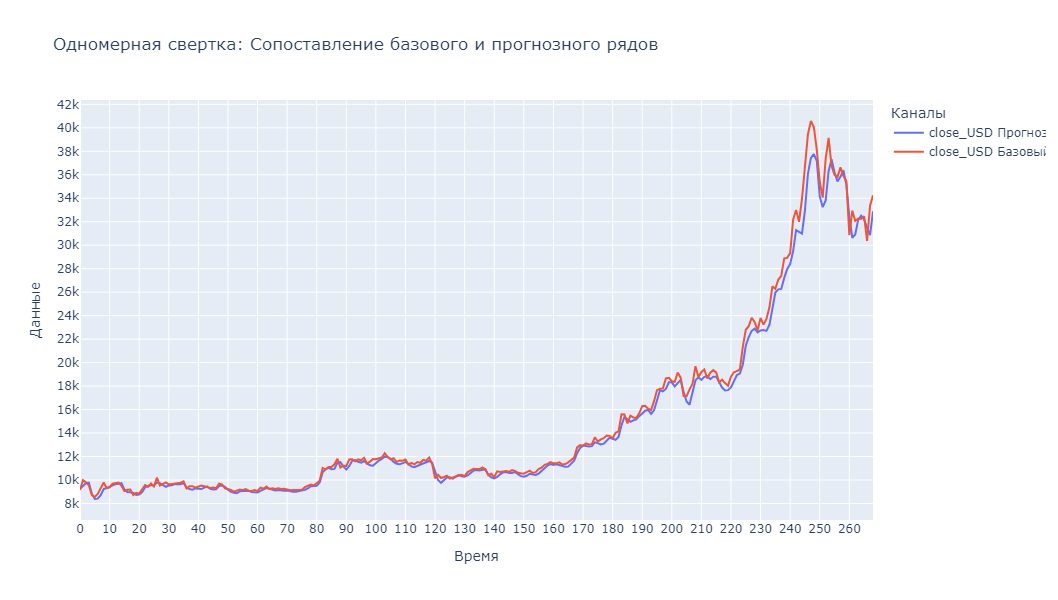

In [140]:
model_conv = Sequential() # Модель Conv1D
model_conv.add(Conv1D(128, 5, input_shape=x_test.shape[1:], activation='relu'))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(100, activation='relu'))
model_conv.add(Dense(32, activation='relu'))
model_conv.add(Dense(y_test.shape[1], activation='linear'))
# Модель Conv1D обучение с разными значениями learning_rate

train_eval_net(model_conv, train_datagen, val_datagen, [(100, Adam(learning_rate=0.0001)),
                                                        (100, Adam(learning_rate=0.00001))],
               x_test, y_test, y_scaler, title='Одномерная свертка')

## Создание и обучение сети с использованием рекуррентного слоя

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 10, 50)            11200     
                                                                 
 lstm_49 (LSTM)              (None, 64)                29440     
                                                                 
 dense_137 (Dense)           (None, 32)                2080      
                                                                 
 dense_138 (Dense)           (None, 16)                528       
                                                                 
 dense_139 (Dense)           (None, 1)                 17        
                                                                 
Total params: 43265 (169.00 KB)
Trainable params: 43265 (169.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Обучение 100 эп

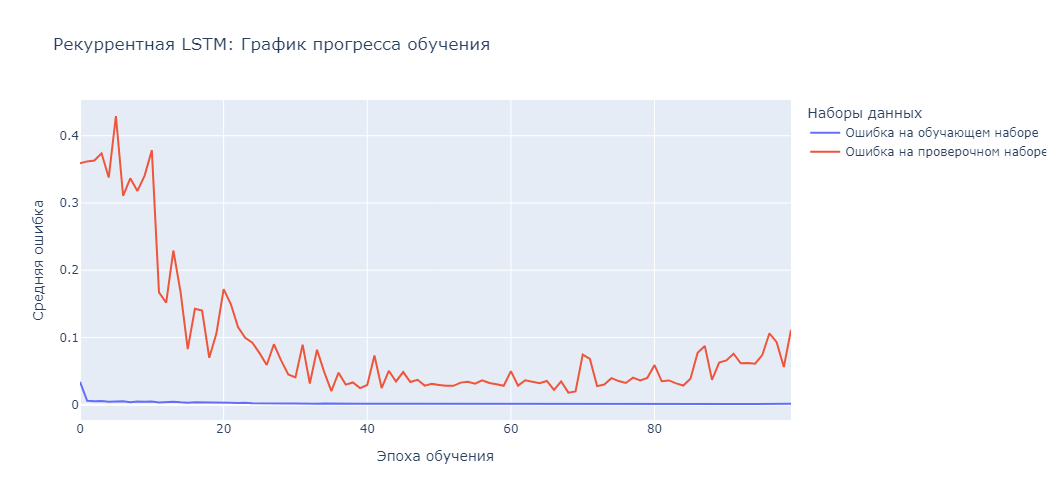

9/9 [==============================] - 0s 2ms/step


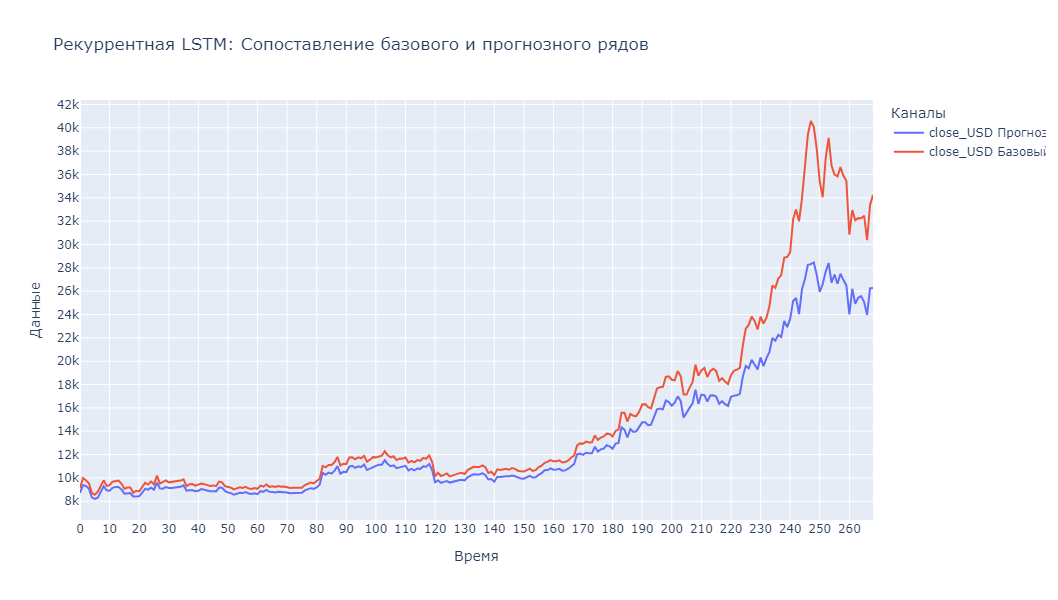

Обучение 100 эпох
Epoch 1/100
44/44 [==============================] - 3s 16ms/step - loss: 0.0011 - val_loss: 0.0724
Epoch 2/100
44/44 [==============================] - 0s 6ms/step - loss: 9.6887e-04 - val_loss: 0.0760
Epoch 3/100
44/44 [==============================] - 0s 5ms/step - loss: 9.6266e-04 - val_loss: 0.0672
Epoch 4/100
44/44 [==============================] - 0s 5ms/step - loss: 9.7758e-04 - val_loss: 0.0640
Epoch 5/100
44/44 [==============================] - 0s 6ms/step - loss: 9.6442e-04 - val_loss: 0.0591
Epoch 6/100
44/44 [==============================] - 0s 6ms/step - loss: 9.5859e-04 - val_loss: 0.0628
Epoch 7/100
44/44 [==============================] - 0s 5ms/step - loss: 9.5718e-04 - val_loss: 0.0643
Epoch 8/100
44/44 [==============================] - 0s 5ms/step - loss: 9.5566e-04 - val_loss: 0.0691
Epoch 9/100
44/44 [==============================] - 0s 5ms/step - loss: 9.5912e-04 - val_loss: 0.0627
Epoch 10/100
44/44 [==============================] - 0s 5

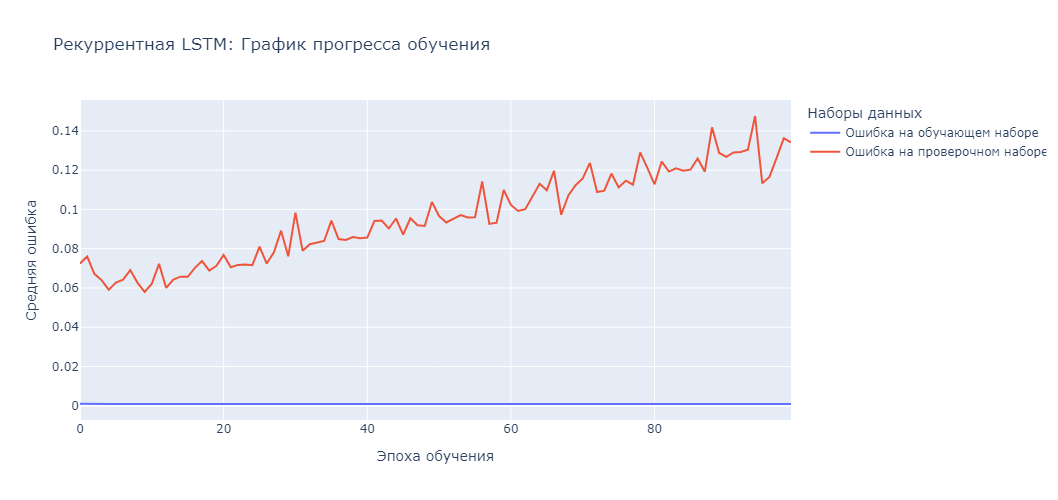

9/9 [==============================] - 0s 2ms/step


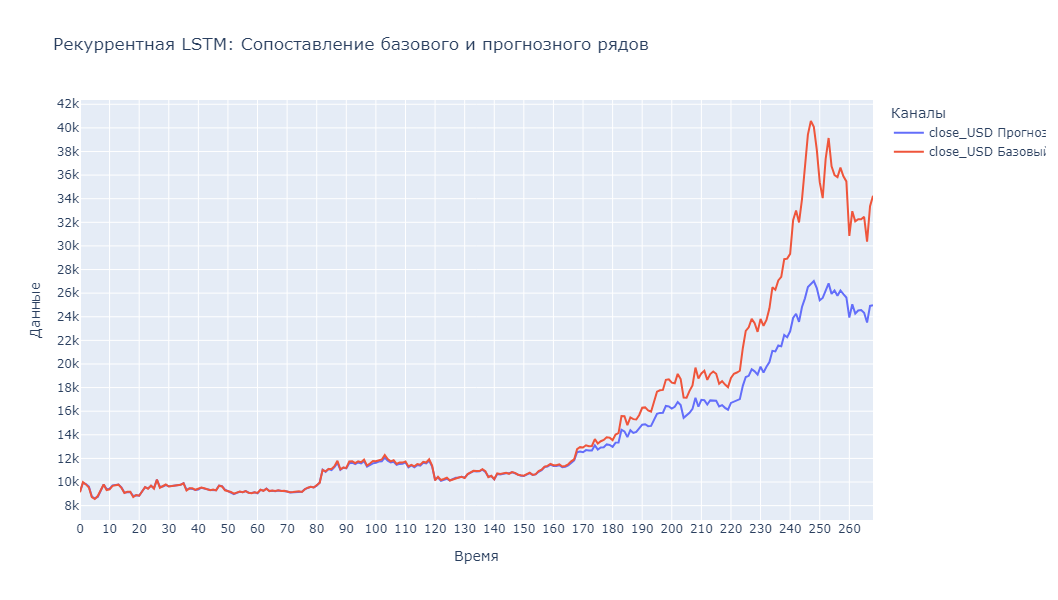

Обучение 100 эпох
Epoch 1/100
44/44 [==============================] - 3s 16ms/step - loss: 8.9249e-04 - val_loss: 0.1369
Epoch 2/100
44/44 [==============================] - 0s 5ms/step - loss: 8.9186e-04 - val_loss: 0.1364
Epoch 3/100
44/44 [==============================] - 0s 6ms/step - loss: 8.9253e-04 - val_loss: 0.1377
Epoch 4/100
44/44 [==============================] - 0s 6ms/step - loss: 8.9294e-04 - val_loss: 0.1369
Epoch 5/100
44/44 [==============================] - 0s 6ms/step - loss: 8.9049e-04 - val_loss: 0.1367
Epoch 6/100
44/44 [==============================] - 0s 6ms/step - loss: 8.9004e-04 - val_loss: 0.1375
Epoch 7/100
44/44 [==============================] - 0s 6ms/step - loss: 8.9116e-04 - val_loss: 0.1375
Epoch 8/100
44/44 [==============================] - 0s 6ms/step - loss: 8.9114e-04 - val_loss: 0.1379
Epoch 9/100
44/44 [==============================] - 0s 6ms/step - loss: 8.8965e-04 - val_loss: 0.1360
Epoch 10/100
44/44 [==============================] - 

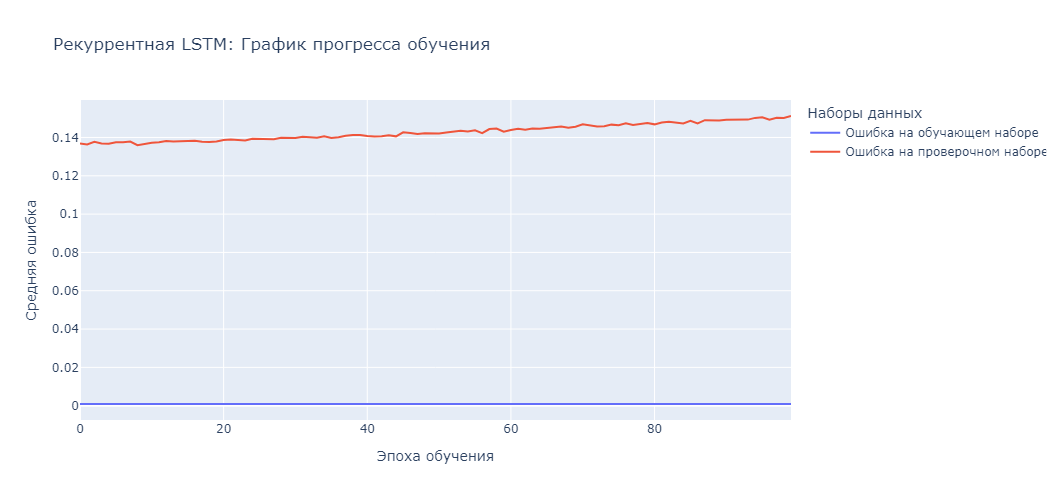

9/9 [==============================] - 0s 2ms/step


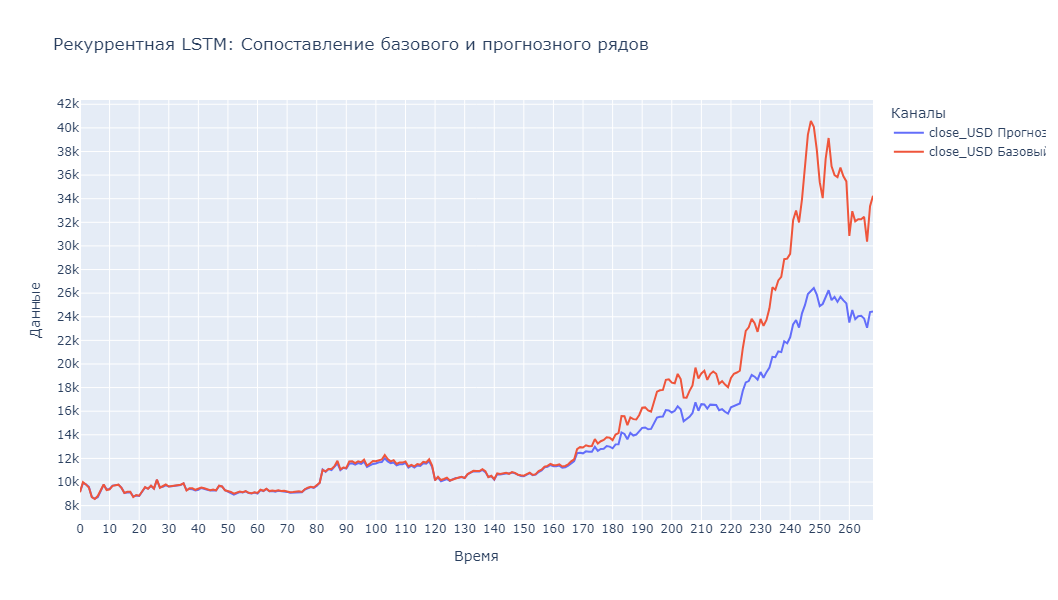

In [142]:
model_lstm = Sequential()  # Модель LSTM
model_lstm.add(LSTM(50, return_sequences= True, input_shape=x_test.shape[1:]))
model_lstm.add(LSTM(64, return_sequences= False))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(y_test.shape[1], activation='linear'))
# Модель LSTM обучение с разными значениями learning_rate
train_eval_net(model_lstm, train_datagen, val_datagen, [(100, Adam(learning_rate=0.001)),
                                                        (100, Adam(learning_rate=0.0001)),
                                                        (100, Adam(learning_rate=0.00001))],
               x_test, y_test, y_scaler, title='Рекуррентная LSTM')

**ВОПРОСЫ**

1. Какую архитектуру сети предпочтительно использовать в задаче прогнозирования значений временных рядов?

**Ваш ответ**   
В задаче прогнозирования временных рядов предпочтительнее использовать архитектуру с рекурентным слоем LSTM. Такая архитектура наиболее точно спрогнозировала временной ряд, за исключением конечного отрезка во временном ряде, это связано с малым количеством данных (всего 1000 экземпляров).





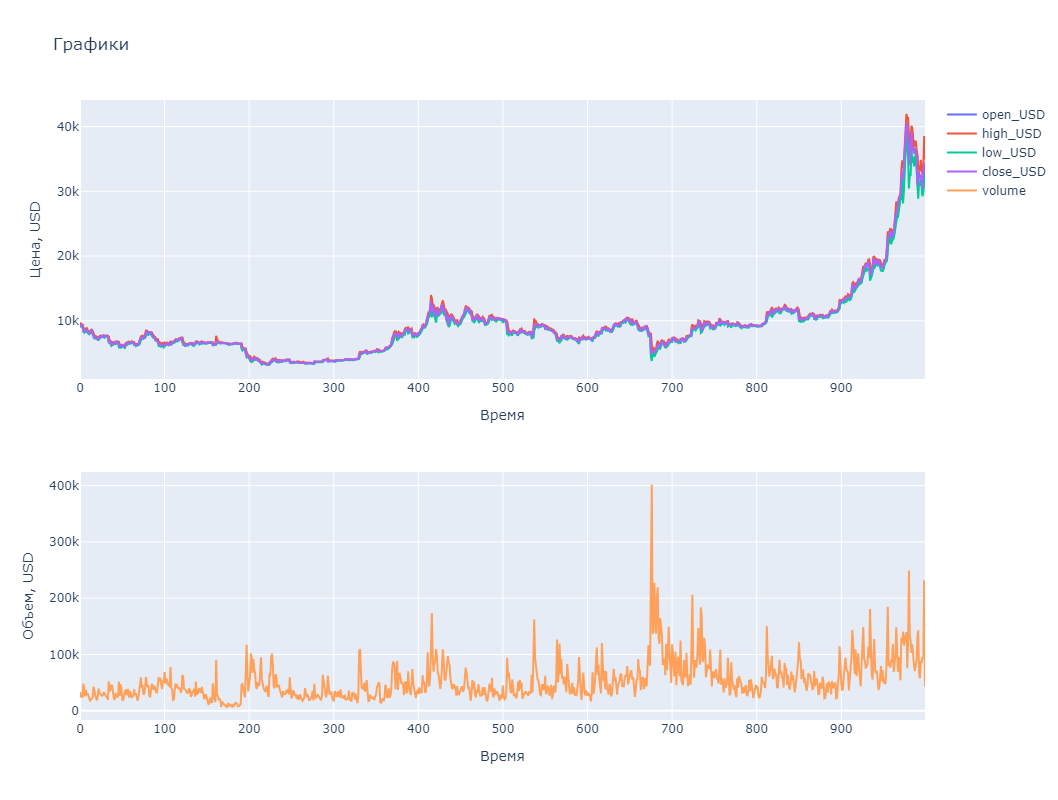

In [148]:
start = 0
length = 1000

fig = go.Figure()

for chn in range(4):
    fig.add_trace(go.Scatter(
        x=list(range(length)),
        y=data[start:start + length, chn],
        mode='lines',
        name=CHANNEL_NAMES[chn],
        yaxis="y1",
        xaxis="x1"
    ))

fig.add_trace(go.Scatter(
    x=list(range(length)),
    y=data[start:start + length, 4],
    mode='lines',
    name=CHANNEL_NAMES[4],
    yaxis="y2",
    xaxis="x2"
))

fig.update_layout(
    title='Графики',
    xaxis1=dict(
        title='Время',
        domain=[0, 1],
        anchor='y1'
    ),
    xaxis2=dict(
        title='Время',
        domain=[0, 1],
        anchor='y2'
    ),
    yaxis=dict(
        title='Цена, USD',
        position=0,
        anchor='x',
        domain=[0.55, 1]
    ),
    yaxis2=dict(
        title='Объем, USD',
        position=0,
        anchor='x',
        domain=[0, 0.4]
    ),
    legend=dict(),
    width=1070, height=800
)

fig.show()